In [5]:
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [16]:
def txt2annotation(path_txt):
    with open(path_txt, 'r') as f:
        annotation = Annotation()
        for line in f:
            if len(line) == 0:
                continue
            start, end, speaker = line.split()
            annotation[Segment(float(start), float(end))] = speaker
        return annotation


# First, a simple test

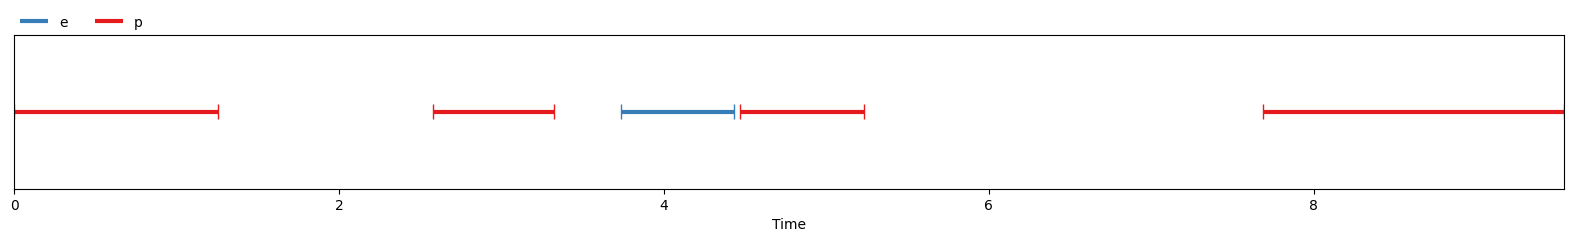

In [19]:
# reference annotation
reference_path = r'combined_database\reference\NP\CETRAM_AMG-0009_VocalSostenida.txt'
reference = txt2annotation(reference_path)
reference

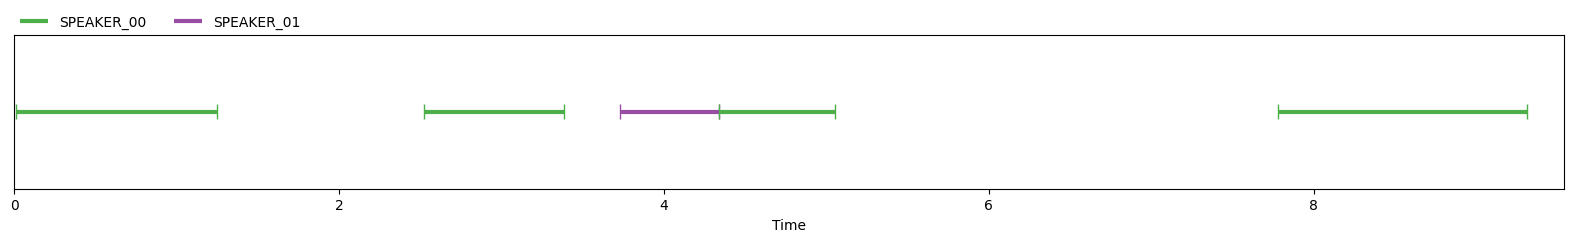

In [20]:
# hypothesis annotation
hypothesis_path = r'combined_database\hypothesis\NP\CETRAM_AMG-0009_VocalSostenida.txt'
hypothesis = txt2annotation(hypothesis_path)
hypothesis

In [25]:
# DER
metric(reference, hypothesis)
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
None                   14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78
None                   14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78
None                   14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78
None                   14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78
None                   14.83  5.32    4.70   88.30        0.17        3.13             0.53      

c:\Users\adolf\diariziation_error_rate\.env\Lib\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


# Let's try to get a cumulative DER based on all reference + hypothesis pairs